In [32]:
from qiskit import IBMQ

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.circuit.library import IntegerComparator
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI
from qiskit.providers.ibmq import least_busy
from qiskit import execute, Aer
from qiskit.qasm import pi

import math

from qiskit.primitives import BackendSampler

In [33]:
IBMQ.save_account('327d163f39d663b2ea92fdbd2ffcdfad071e02392bea2944dfee1679b8e14f734e3d9fbcc8d8b18c39990ec47458a2d25e43533a2f979b8c28bedb9e24eed525')

configrc.store_credentials:WARNING:2024-04-16 12:09:50,320: Credentials already present. Set overwrite=True to overwrite.


In [34]:
# 自分のアカウント情報をloadする。（あらかじめ IBMQ.save_account を実行しておく必要がある. 複数のアカウントを使い分ける時はここで行う)
provider = IBMQ.load_account()

# 自分のアカウントで使用できるバックエンドを見る
provider.backends()

ibmqfactory.load_account:WARNING:2024-04-16 12:09:52,445: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_brisbane') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_kyoto') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_osaka') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [35]:
backend_lb = least_busy(provider.backends(simulator=False, operational=True))
print("Least busy backend: ", backend_lb)

#least busyだったbackendを選ぶ
backend_sim = backend_lb

#量子回路qcを指定したバックエンド(backend_sim)で4096回実行する。
#result = execute(qc, backend_sim, shots=4096).result()

#結果を出力する。
#print(result.get_counts(qc))

Least busy backend:  ibm_osaka


In [36]:
num = 5 #株の数（もしくは変動日数）
theta = math.pi/2 #株の上下変動のしやすさ

In [37]:
qc = QuantumCircuit(num)

for i in range(num):
    qc.ry(theta,i)

qc_measure = qc.measure_all(inplace=False)

qc.draw()

┌─────────┐
q_0: ┤ Ry(π/2) ├
     ├─────────┤
q_1: ┤ Ry(π/2) ├
     ├─────────┤
q_2: ┤ Ry(π/2) ├
     ├─────────┤
q_3: ┤ Ry(π/2) ├
     ├─────────┤
q_4: ┤ Ry(π/2) ├
     └─────────┘

In [38]:
from qiskit.circuit.library import WeightedAdder
from qiskit.circuit.library import LinearAmplitudeFunction

agg = WeightedAdder(num, [8,9,10,11,12])

qr_state = QuantumRegister(qc.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits+1, "carry")
cr = ClassicalRegister(agg.num_sum_qubits, "value")

L_sum_state = QuantumCircuit(qr_state, qr_sum, qr_carry, cr)

# load the variable
L_sum_state.append(qc.to_gate(), qr_state)

# aggregate
L_sum_state.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])

L_sum_state.measure(qr_sum[:],cr[:])

L_sum_state.draw()

┌──────────────┐┌─────────┐                  
state_0: ┤0             ├┤0        ├──────────────────
         │              ││         │                  
state_1: ┤1             ├┤1        ├──────────────────
         │              ││         │                  
state_2: ┤2 circuit-466 ├┤2        ├──────────────────
         │              ││         │                  
state_3: ┤3             ├┤3        ├──────────────────
         │              ││         │                  
state_4: ┤4             ├┤4        ├──────────────────
         └──────────────┘│         │┌─┐               
  sum_0: ────────────────┤5        ├┤M├───────────────
                         │         │└╥┘┌─┐            
  sum_1: ────────────────┤6        ├─╫─┤M├────────────
                         │         │ ║ └╥┘┌─┐         
  sum_2: ────────────────┤7        ├─╫──╫─┤M├─────────
                         │         │ ║  ║ └╥┘┌─┐      
  sum_3: ────────────────┤8  adder ├─╫──╫──╫─┤M├──────
                         │         │ ║  ║  ║ └╥┘┌─┐   
  sum_4: ────────────────┤9        ├─╫──╫──╫──╫─┤M├───
                         │         │ ║  ║  ║  ║ └╥┘┌─┐
  sum_5: ────────────────┤10       ├─╫──╫──╫──╫──╫─┤M├
                         │         │ ║  ║  ║  ║  ║ └╥┘
carry_0: ────────────────┤11       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_1: ────────────────┤12       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_2: ────────────────┤13       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_3: ────────────────┤14       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_4: ────────────────┤15       ├─╫──╫──╫──╫──╫──╫─
                         │         │ ║  ║  ║  ║  ║  ║ 
carry_5: ────────────────┤16       ├─╫──╫──╫──╫──╫──╫─
                         └─────────┘ ║  ║  ║  ║  ║  ║ 
value: 6/════════════════════════════╩══╩══╩══╩══╩══╩═
                                     0  1  2  3  4  5

In [39]:
sampler = BackendSampler(backend=backend_sim)
job = sampler.run(L_sum_state)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [40]:
qubit_state_L = []

for i, prob in binary_probabilities.items():
    print(i,prob)
    qubit_state_L.append([i,prob])

qubit_state_L.sort()

111111 0.00275
101010 0.01225
010010 0.01375
010000 0.01575
010100 0.012
001001 0.03525
110101 0.00475
001000 0.0355
111101 0.00525
101011 0.00775
101101 0.01
000011 0.02975
111110 0.006
001011 0.03175
110000 0.00425
111100 0.00475
011110 0.0135
101100 0.01275
100100 0.011
000111 0.034
000010 0.03075
000001 0.03725
111001 0.0045
001010 0.0325
000110 0.03975
001110 0.0375
000000 0.03425
010011 0.01175
110010 0.00275
100011 0.00775
110001 0.00375
011101 0.017
100101 0.00975
110011 0.00275
001111 0.029
011010 0.012
001100 0.04275
111011 0.00325
010101 0.014
111010 0.003
011111 0.0135
101000 0.01025
101001 0.007
100111 0.01
011001 0.0145
110111 0.00225
010110 0.017
011100 0.014
101110 0.0075
101111 0.0105
011011 0.01025
111000 0.00325
000101 0.031
100001 0.0085
110110 0.00475
100000 0.01025
000100 0.04075
110100 0.006
011000 0.014
100110 0.01075
010111 0.01475
100010 0.01
010001 0.01175
001101 0.03875


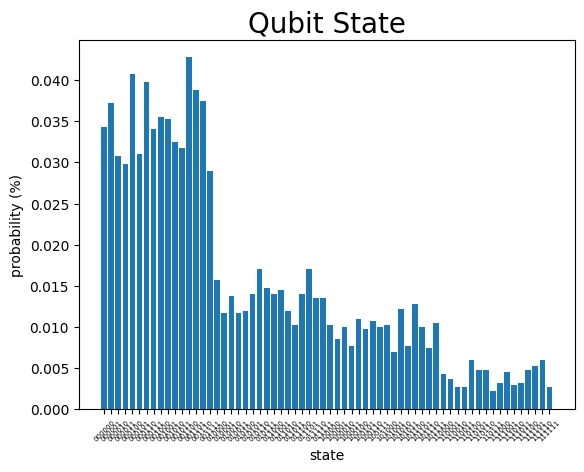

In [41]:
# plot probabilities of each states
q_state_L = []
q_prob_L = []
for state in qubit_state_L:
    q_state_L.append(state[0])
    q_prob_L.append(state[1])

plt.bar(q_state_L,q_prob_L)
#plt.legend(fontsize=15)
plt.xlabel("state", size=10)
plt.ylabel("probability (%)", size=10)
plt.title("Qubit State", size=20)
plt.xticks(size=5,rotation=45)
plt.yticks(size=10)
plt.show()